In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from edward.models import Normal
import edward as ed
from sklearn.kernel_ridge import KernelRidge

In [2]:
x_train = np.linspace(-2.8, 2.8, num=50)
y_train = (x_train - 3) * (x_train + 3)* 2 /(-9.) - 5. + np.random.normal(0, 0.1, size=50)
x_train = x_train.astype(np.float32).reshape((50, 1))
y_train = y_train.astype(np.float32).reshape((50, 1))

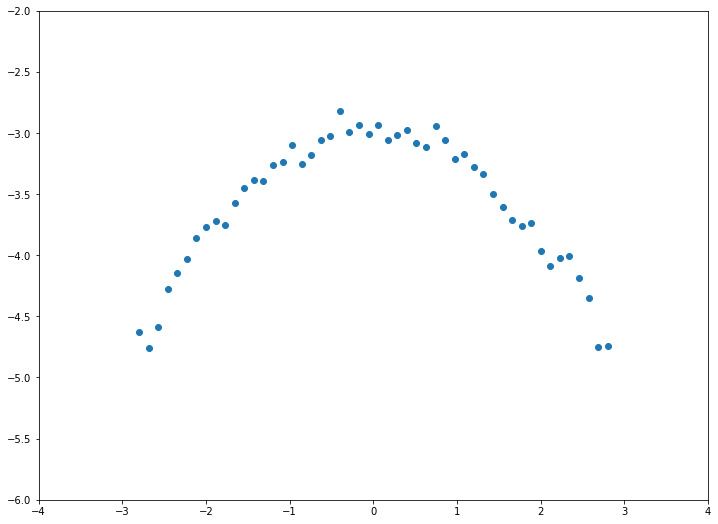

In [3]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.scatter(x_train, y_train, marker='o')
ax.set_xlim((-4, 4))
ax.set_ylim((-6, -2))
plt.show()

In [4]:
# kernel_reg = KernelRidge(kernel='rbf')
# kernel_reg.fit(x_train, y_train)

In [5]:
# fig, ax = plt.subplots()
# ax.scatter(x_train, y_train, marker='.')
# inputs = np.linspace(-4, 4, 100)
# outputs = kernel_reg.predict(inputs.reshape(100, 1))
# ax.plot(inputs, outputs)
# ax.set_xlim((-4, 4))
# ax.set_ylim((-6, 1))
# plt.show()

# Bayesian Neural Network

In [6]:
W_0 = Normal(loc=tf.zeros([1, 3]), scale=tf.ones([1, 3]))
W_1 = Normal(loc=tf.zeros([3, 1]), scale=tf.ones([3, 1]))
b_0 = Normal(loc=tf.zeros(3), scale=tf.ones(3))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

# inputs
x = tf.placeholder(tf.float32, [None, 1])

# hidden layer
h1 = tf.matmul(x, W_0) + b_0
h1 = tf.nn.relu(h1)

# output
h2 = tf.matmul(h1, W_1) + b_1
y = tf.identity(h2)

y = Normal(loc=y, #tf.matmul(tf.nn.relu(tf.matmul(x, W_0) + b_0), W_1) + b_1,
           scale=0.1)

In [7]:
qW_0 = Normal(loc=tf.get_variable("qW_0/loc", [1, 3]),
              scale=tf.nn.softplus(tf.get_variable("qW_0/scale", [1, 3])))
qW_1 = Normal(loc=tf.get_variable("qW_1/loc", [3, 1]),
              scale=tf.nn.softplus(tf.get_variable("qW_1/scale", [3, 1])))
qb_0 = Normal(loc=tf.get_variable("qb_0/loc", [3]),
              scale=tf.nn.softplus(tf.get_variable("qb_0/scale", [3])))
qb_1 = Normal(loc=tf.get_variable("qb_1/loc", [1]),
              scale=tf.nn.softplus(tf.get_variable("qb_1/scale", [1])))

In [8]:
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1}, data={x: x_train, y: y_train})
inference.run(n_iter=2000)

2000/2000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: 1.330


In [9]:
y_post = ed.copy(y, {W_0: qW_0, b_0: qb_0, 
                     W_1: qW_1, b_1: qb_1}).eval(feed_dict={x: x_train})

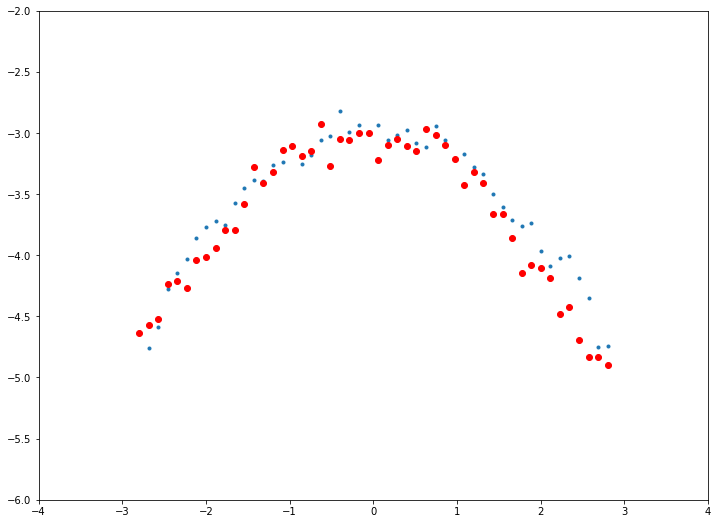

In [10]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.scatter(x_train, y_train, marker='.')
ax.scatter(x_train, y_post, c='r')
ax.set_xlim((-4, 4))
ax.set_ylim((-6, -2))
plt.show()

In [11]:
def visualize(x_data, y_data, W_0, b_0, W_1, b_1, n_samples=10, n_pts=100):
    fig, ax = plt.subplots(figsize=(12, 9))
    inputs = np.linspace(-7, 7, n_pts).reshape(n_pts, 1).astype(np.float32)
    plt.plot(inputs, (inputs - 3) * (inputs + 3)* 2 /(-9.) - 5., c='black')
    plt.scatter(x_data, y_data)
    draws = []
    for ns in range(n_samples):
        outputs = ed.copy(y, {W_0: qW_0, b_0: qb_0, 
                              W_1: qW_1, b_1: qb_1}).eval(feed_dict={x: inputs})
        draws.append(outputs.reshape(-1))
    mu = np.mean(np.array(draws), axis=0)
    std = np.std(np.array(draws), axis=0)
    plt.plot(inputs.reshape(-1), mu, c='r')
    plt.fill_between(inputs.reshape(-1), mu-2*std, mu+2*std, color='grey', alpha='0.5')
    plt.show()

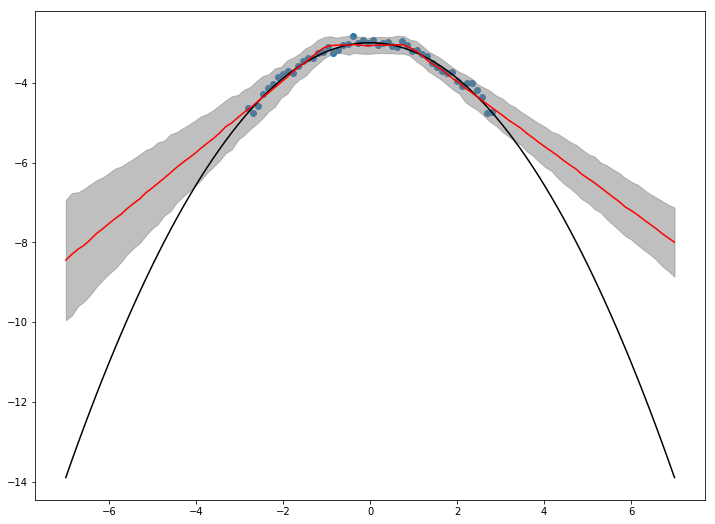

In [12]:
visualize(x_train, y_train, qW_0, qb_0, qW_1, qb_1, n_samples=100)

# Vanilla Neural Network

In [15]:
tf.reset_default_graph()

# weights and biases 
W_2 = tf.get_variable('W_2', shape=[1, 3], initializer=tf.random_normal_initializer())
W_3 = tf.get_variable('W_3', shape=[3, 1], initializer=tf.random_normal_initializer())
b_2 = tf.get_variable('b_2', shape=[3], initializer=tf.zeros_initializer())
b_3 = tf.get_variable('b_3', shape=[1], initializer=tf.zeros_initializer())

# inputs
x = tf.placeholder(tf.float32, [None, 1])
labels = tf.placeholder(tf.float32, [None, 1])

# hidden layer 
h1 = tf.matmul(x, W_2) + b_2
h1 = tf.nn.relu(h1)

# output
h2 = tf.matmul(h1, W_3) + b_3
y = tf.identity(h2)

# loss
mse = tf.losses.mean_squared_error(labels, y)
regularization = tf.nn.l2_loss(W_2) + tf.nn.l2_loss(W_3)
loss = mse + 0.001 * regularization

train_op = tf.train.AdamOptimizer(1e-2).minimize(loss)

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(1, 50001):
        if i % 5000 == 0:
            current_loss = sess.run(loss, feed_dict={x : x_train, labels : y_train})
            print('batch {} | loss : {}'.format(i, current_loss))
        sess.run(train_op, feed_dict={x : x_train, labels : y_train})
        
    ip_for_plotting = np.linspace(-7, 7, 100).reshape(100, 1).astype(np.float32)
    op_for_plotting = sess.run(y, feed_dict={x : ip_for_plotting})

batch 5000 | loss : 0.012067783623933792
batch 10000 | loss : 0.011316079646348953
batch 15000 | loss : 0.011315284296870232
batch 20000 | loss : 0.011360416188836098
batch 25000 | loss : 0.011315295472741127
batch 30000 | loss : 0.011315287090837955
batch 35000 | loss : 0.01131528615951538
batch 40000 | loss : 0.011315285228192806
batch 45000 | loss : 0.01131528988480568
batch 50000 | loss : 0.01131528988480568


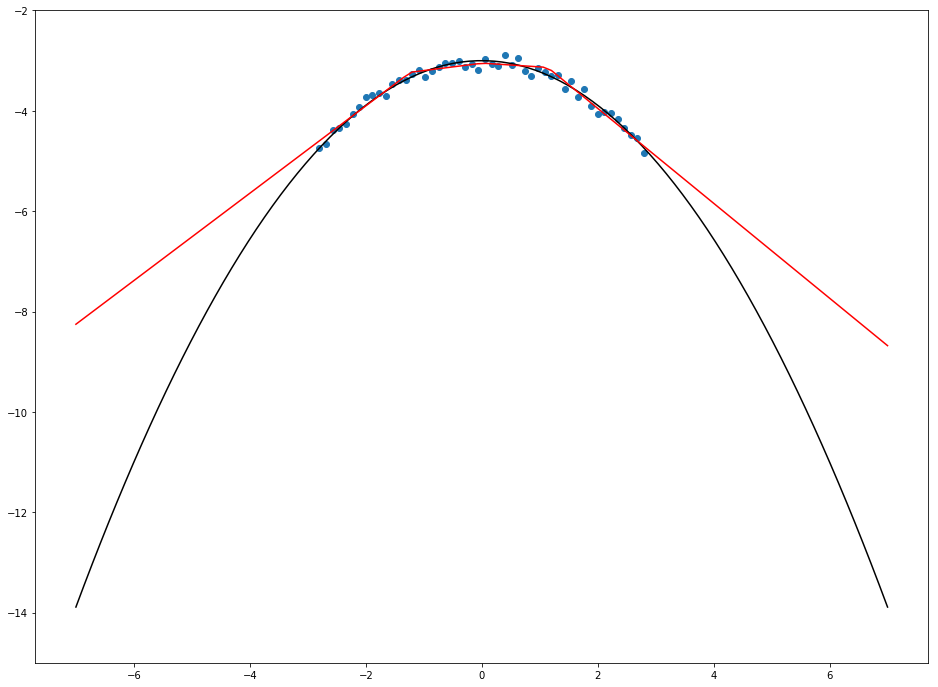

In [17]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(ip_for_plotting, (ip_for_plotting - 3) * (ip_for_plotting + 3)* 2 /(-9.) - 5., c='black')
ax.plot(ip_for_plotting.reshape(-1), op_for_plotting.reshape(-1), c='r')
ax.scatter(x_train, y_train)
ax.set_ylim((-15, -2))
plt.show()

# Dropout

In [18]:
tf.reset_default_graph()

# weights and biases 
W_2 = tf.get_variable('W_2', shape=[1, 3], initializer=tf.random_normal_initializer())
W_3 = tf.get_variable('W_3', shape=[3, 1], initializer=tf.random_normal_initializer())
b_2 = tf.get_variable('b_2', shape=[3], initializer=tf.zeros_initializer())
b_3 = tf.get_variable('b_3', shape=[1], initializer=tf.zeros_initializer())

# dropout keep probability
keep_prob = tf.placeholder(tf.float32)

# inputs
x = tf.placeholder(tf.float32, [None, 1])
labels = tf.placeholder(tf.float32, [None, 1])

# hidden layer 
h1 = tf.matmul(tf.nn.dropout(x, keep_prob=keep_prob), W_2) + b_2
h1 = tf.nn.relu(h1)

# output
h2 = tf.matmul(tf.nn.dropout(h1, keep_prob=keep_prob), W_3) + b_3
y = tf.identity(h2)

# loss
mse = tf.losses.mean_squared_error(labels, y)
regularization = tf.nn.l2_loss(W_2) + tf.nn.l2_loss(W_3)
loss = mse + 0.001 * regularization

train_op = tf.train.AdamOptimizer(1e-2).minimize(loss)

In [19]:
kp = 0.8

In [20]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(1, 50001):
        if i % 5000 == 0:
            current_loss = sess.run(loss, feed_dict={x : x_train, labels : y_train, keep_prob : kp})
            print('batch {} | loss : {:.5f}'.format(i, current_loss))
        sess.run(train_op, feed_dict={x : x_train, labels : y_train, keep_prob : kp})
        
    ip_dropout = np.linspace(-7, 7, 100).reshape(100, 1).astype(np.float32)
    op_dropout_off = sess.run(y, feed_dict={x : ip_for_plotting, keep_prob : 1.0})
    
    op_dropout_on = []
    for i in range(100):
        op_dropout_on.append(sess.run(y, feed_dict={x : ip_for_plotting, keep_prob : kp}))
    op_mu = np.mean(np.array(op_dropout_on), axis=0)
    op_std = np.std(np.array(op_dropout_on), axis=0)

batch 5000 | loss : 0.11099
batch 10000 | loss : 0.17198
batch 15000 | loss : 0.15810
batch 20000 | loss : 0.13660
batch 25000 | loss : 0.15503
batch 30000 | loss : 0.11434
batch 35000 | loss : 0.15550
batch 40000 | loss : 0.12765
batch 45000 | loss : 0.16035
batch 50000 | loss : 0.13226


# "Deterministic" Dropout

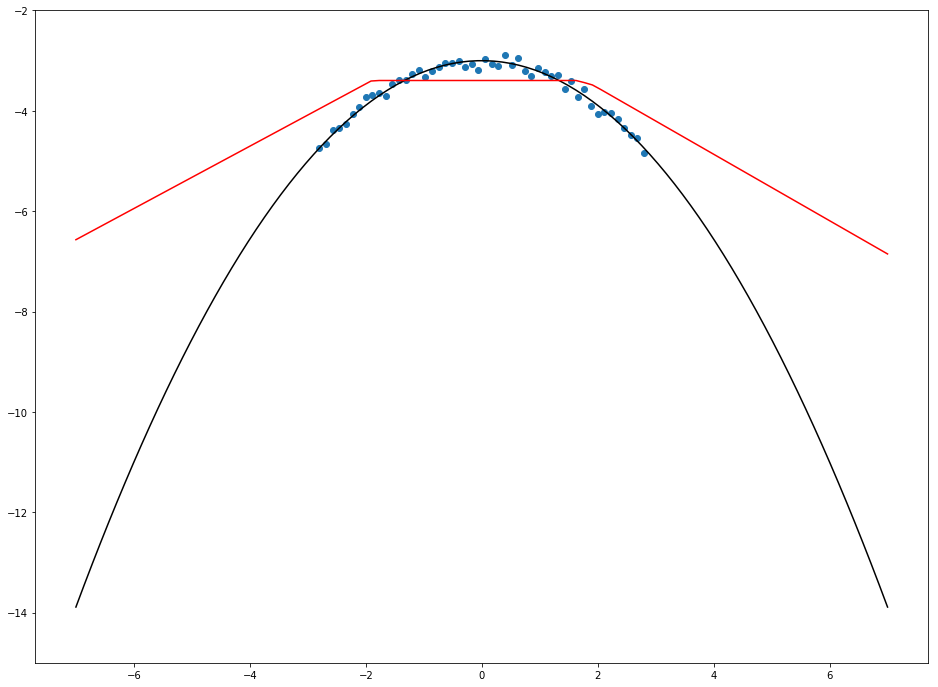

In [21]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(ip_dropout, (ip_dropout - 3) * (ip_dropout + 3)* 2 /(-9.) - 5., c='black')
ax.plot(ip_dropout.reshape(-1), op_dropout_off.reshape(-1), c='r')
ax.scatter(x_train, y_train)
ax.set_ylim((-15, -2))
plt.show()

# "Probabilistic" Dropout 

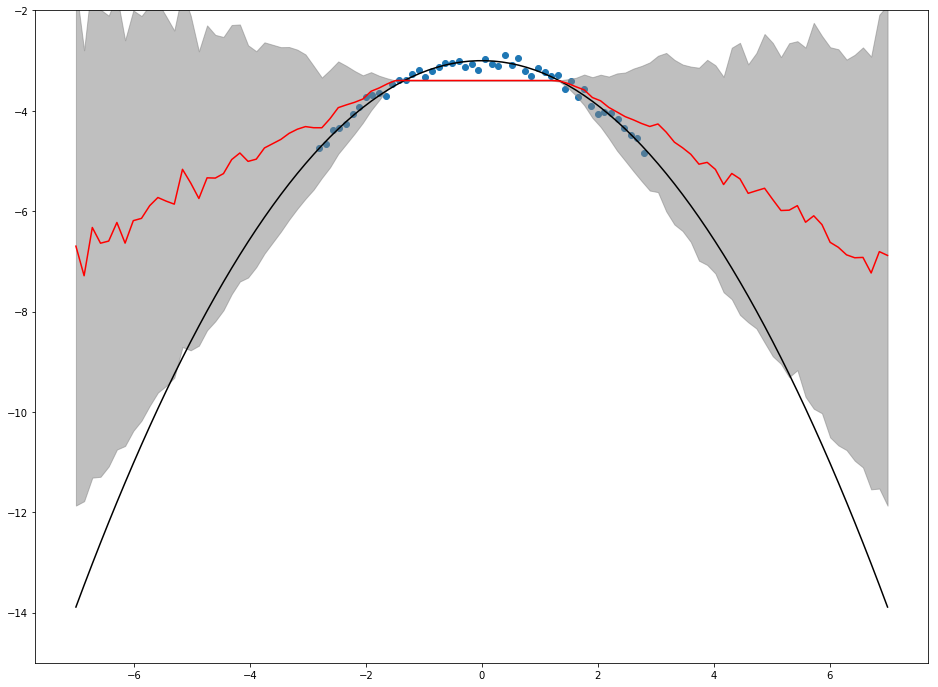

In [22]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(ip_dropout, (ip_dropout - 3) * (ip_dropout + 3)* 2 /(-9.) - 5., c='black')
ax.plot(ip_dropout.reshape(-1), op_mu.reshape(-1), c='r')
ax.scatter(x_train, y_train)
plt.fill_between(ip_dropout.reshape(-1), (op_mu-2*op_std).reshape(-1), (op_mu+2*op_std).reshape(-1), color='grey', alpha='0.5')
ax.set_ylim((-15, -2))
plt.show()